In [1]:
import torch as pt
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

In [3]:
device = "cuda" if pt.cuda.is_available() else "cpu"
latent_dim = 100
batch_size = 64
gen_lr = 2e-4
disc_lr = 2e-4
epochs = 30
stats = (0.5), (0.5)

In [4]:
train_dataset = MNIST("./data", train=True, download=True, transform=transforms_)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST("./data", train=False, download=True, transform=transforms_)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
def show_images(images, n_max=batch_size):
    _, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach().cpu()[:n_max]).permute(1, 2, 0))

In [7]:
from torch import nn
from torch.nn import functional as F

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # latent_dim size: (64, 100, 1, 1) i.e. (B, C, H, W) format
        self.conv_transpose_block1 = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=9, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Height = 1 * (1 - 1) + 9 - 2*0 (Stride - (image height - 1) + kernel size - 2*padding)
            # = 1 * (0) + 9 - (0)
            # = 9
            # (64, 128, 9, 9) (9x9 because height and width are the same)

            nn.ConvTranspose2d(128, 64, kernel_size=6, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Height = 1 * (9 - 1) + 6 - 2*0
            # = 1 * (8) + 6 - (0)
            # = 8 + 6
            # = 14
            # (64, 64, 14, 14) (14x14 because height and width are the same)

            nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # Height = 2 * (14 - 1) + 4 - 2*1
            # = 2 * (13) + 4 - (2)
            # = 26 + 2
            # = 28
            # (64, 32, 28, 28) (28x28 because height and width are the same)

            nn.ConvTranspose2d(32, 28, kernel_size=4, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(28),
            nn.ReLU(True),
            # Height = 2 * (28 - 1) + 4 - 2*1
            # = 2 * (27) + 4 - (2)
            # = 54 + 2
            # = 56
            # (64, 28, 56, 56) (56x56 because height and width are the same)

            nn.Conv2d(28, 1, kernel_size=3, padding=1, stride=2, bias=True),
            # (W – F + 2P) / S + 1
            # (56 - 3 + (2*1)) / 2 + 1
            # (53 + 2) / 2 + 1
            # 27.5 + 1
            # 28
        )

    def forward(self, x):
        x = self.conv_transpose_block1(x)
        return F.tanh(x)

/home/parth/miniconda3/envs/env-pytorch/lib/python3.8/site-packages/torch/nn/modules/conv.py:956: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv_transpose2d(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])


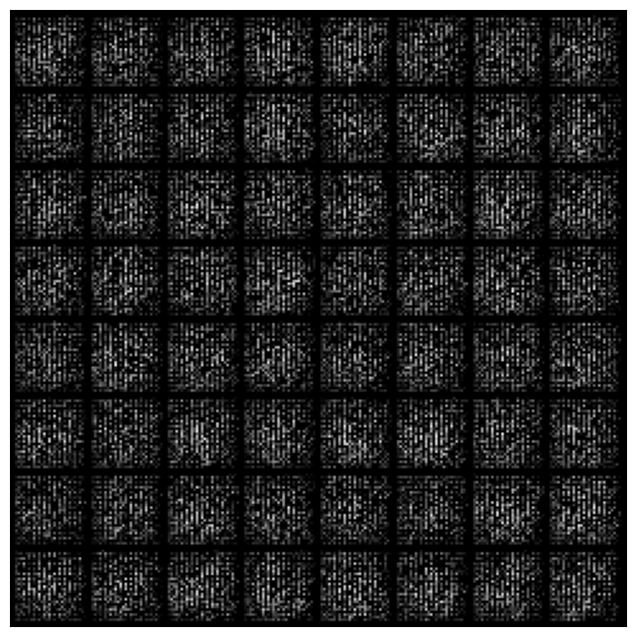

In [9]:
generator = Generator(latent_dim).to(device)

xb = pt.randn(batch_size, latent_dim, 1, 1) # random latent tensors - (B, C, H, W)
fake_images = generator(xb.to(device))
print(fake_images.shape)
show_images(fake_images)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2, inplace=True),
            # (28 – 3 + (2*1)) / 1 + 1 = 28 / maxpool = 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2, inplace=True),
            # (14 – 3 + (2*1)) / 1 + 1 = 14 / maxpool = 7
        )
        self.dense1 = nn.Linear(128*7*7, 1)

    def forward(self, x):
        x = self.discriminator(x)
        x = x.view(-1, 128*7*7)
        x = self.dense1(x)
        return F.sigmoid(x)

In [11]:
discriminator = Discriminator().to(device)

In [12]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = pt.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator.train()(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = pt.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [13]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator.train()(real_images)
    real_targets = pt.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    # real_score = pt.mean(real_preds).item()

    # Generate fake images
    latent = pt.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator.train()(latent)

    # Pass fake images through discriminator
    fake_targets = pt.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator.train()(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    # fake_score = pt.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss # (... + ...) / 2
    loss.backward()
    opt_d.step()
    return loss.item(), real_loss.detach().cpu().item(), fake_loss.detach().cpu().item() # real_score, fake_score

In [14]:
import os

sample_dir = 'generated-images'
os.makedirs(sample_dir, exist_ok=True)

In [15]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator.eval()(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(
        fake_images.detach().cpu(),
        os.path.join(sample_dir, fake_fname),
        nrow=8
    )
    print(f"Saving {fake_fname}...")
    if show:
        _, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.detach().cpu(), nrow=8).permute(1, 2, 0))
        plt.show()

In [16]:
opt_g = pt.optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
opt_d = pt.optim.Adam(discriminator.parameters(), lr=disc_lr, betas=(0.5, 0.999))

fixed_latent = pt.randn(64, latent_dim, 1, 1, device=device)

In [17]:
import numpy as np
from tqdm import tqdm

In [18]:
losses_g, losses_d = [], []
real_scores, fake_scores = [], []

for epoch in range(epochs):
    batch_loss_g, batch_loss_d = [], []
    batch_real_score, batch_fake_score = [], []

    for loader in train_loader, test_loader:
        # Train discriminator
        for real_images, _ in tqdm(loader):
            loss_d, real_score, fake_score = train_discriminator(real_images.to(device), opt_d)
            batch_loss_d.append(loss_d)
            batch_real_score.append(real_score)
            batch_fake_score.append(fake_score)
            # Train generator
            loss_g = train_generator(opt_g)
            batch_loss_g.append(loss_g)

    # Record losses & scores
    losses_g.append(np.mean(batch_loss_g))
    losses_d.append(np.mean(batch_loss_d))
    real_scores.append(np.mean(batch_real_score))
    fake_scores.append(np.mean(batch_fake_score))

    batch_loss_g, batch_loss_d = [], []
    batch_real_score, batch_fake_score = [], []

    # Save generated images
    save_samples(epoch+1, fixed_latent, show=False)

    # Log losses & scores (last batch)
    print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f},"
          + f" real_score: {real_score:.4f}, fake_score: {fake_score:.4f}\n")

100%|██████████| 157/157 [00:04<00:00, 32.59it/s]


Saving generated-images-0001.png...
Epoch [1/30], loss_g: 0.9945, loss_d: 1.2040, real_score: 0.5563, fake_score: 0.6477



100%|██████████| 157/157 [00:04<00:00, 32.38it/s]


Saving generated-images-0002.png...
Epoch [2/30], loss_g: 1.2674, loss_d: 1.2503, real_score: 0.3479, fake_score: 0.9024



100%|██████████| 157/157 [00:04<00:00, 32.45it/s]


Saving generated-images-0003.png...
Epoch [3/30], loss_g: 0.9656, loss_d: 1.1409, real_score: 0.5702, fake_score: 0.5707



100%|██████████| 157/157 [00:05<00:00, 30.69it/s]


Saving generated-images-0004.png...
Epoch [4/30], loss_g: 0.6087, loss_d: 1.2638, real_score: 0.7621, fake_score: 0.5017



100%|██████████| 157/157 [00:04<00:00, 32.14it/s]


Saving generated-images-0005.png...
Epoch [5/30], loss_g: 1.1206, loss_d: 1.4395, real_score: 0.3947, fake_score: 1.0448



100%|██████████| 157/157 [00:04<00:00, 32.24it/s]


Saving generated-images-0006.png...
Epoch [6/30], loss_g: 0.5590, loss_d: 1.5449, real_score: 1.0894, fake_score: 0.4555



100%|██████████| 157/157 [00:04<00:00, 32.30it/s]


Saving generated-images-0007.png...
Epoch [7/30], loss_g: 0.9372, loss_d: 1.3596, real_score: 0.5606, fake_score: 0.7990



100%|██████████| 157/157 [00:04<00:00, 31.61it/s]


Saving generated-images-0008.png...
Epoch [8/30], loss_g: 0.4829, loss_d: 1.4873, real_score: 0.9732, fake_score: 0.5141



100%|██████████| 157/157 [00:04<00:00, 32.16it/s]


Saving generated-images-0009.png...
Epoch [9/30], loss_g: 0.6653, loss_d: 1.4009, real_score: 0.5933, fake_score: 0.8076



100%|██████████| 157/157 [00:04<00:00, 32.25it/s]


Saving generated-images-0010.png...
Epoch [10/30], loss_g: 0.5798, loss_d: 1.4323, real_score: 0.8700, fake_score: 0.5624



100%|██████████| 157/157 [00:04<00:00, 32.23it/s]


Saving generated-images-0011.png...
Epoch [11/30], loss_g: 0.6114, loss_d: 1.3925, real_score: 0.8523, fake_score: 0.5402



100%|██████████| 157/157 [00:04<00:00, 32.34it/s]


Saving generated-images-0012.png...
Epoch [12/30], loss_g: 0.8970, loss_d: 1.2089, real_score: 0.6127, fake_score: 0.5962



100%|██████████| 157/157 [00:04<00:00, 32.15it/s]


Saving generated-images-0013.png...
Epoch [13/30], loss_g: 0.7680, loss_d: 1.3899, real_score: 0.7163, fake_score: 0.6736



100%|██████████| 157/157 [00:04<00:00, 32.22it/s]


Saving generated-images-0014.png...
Epoch [14/30], loss_g: 0.9282, loss_d: 1.2121, real_score: 0.5902, fake_score: 0.6218



100%|██████████| 157/157 [00:04<00:00, 32.07it/s]


Saving generated-images-0015.png...
Epoch [15/30], loss_g: 0.9167, loss_d: 1.2860, real_score: 0.6854, fake_score: 0.6006



100%|██████████| 157/157 [00:04<00:00, 32.08it/s]


Saving generated-images-0016.png...
Epoch [16/30], loss_g: 1.0124, loss_d: 1.3028, real_score: 0.5304, fake_score: 0.7724



100%|██████████| 157/157 [00:04<00:00, 31.99it/s]


Saving generated-images-0017.png...
Epoch [17/30], loss_g: 0.7363, loss_d: 1.3232, real_score: 0.6710, fake_score: 0.6522



100%|██████████| 157/157 [00:04<00:00, 32.04it/s]


Saving generated-images-0018.png...
Epoch [18/30], loss_g: 0.8370, loss_d: 1.2539, real_score: 0.6619, fake_score: 0.5920



100%|██████████| 157/157 [00:04<00:00, 32.01it/s]


Saving generated-images-0019.png...
Epoch [19/30], loss_g: 0.8999, loss_d: 1.2451, real_score: 0.6207, fake_score: 0.6244



100%|██████████| 157/157 [00:04<00:00, 31.95it/s]


Saving generated-images-0020.png...
Epoch [20/30], loss_g: 0.6784, loss_d: 1.4260, real_score: 0.8644, fake_score: 0.5616



100%|██████████| 157/157 [00:04<00:00, 32.05it/s]


Saving generated-images-0021.png...
Epoch [21/30], loss_g: 0.7108, loss_d: 1.3667, real_score: 0.8207, fake_score: 0.5459



100%|██████████| 157/157 [00:04<00:00, 31.94it/s]


Saving generated-images-0022.png...
Epoch [22/30], loss_g: 0.6511, loss_d: 1.4547, real_score: 1.0121, fake_score: 0.4426



100%|██████████| 157/157 [00:04<00:00, 31.90it/s]


Saving generated-images-0023.png...
Epoch [23/30], loss_g: 1.4113, loss_d: 1.4231, real_score: 0.3888, fake_score: 1.0343



100%|██████████| 157/157 [00:04<00:00, 32.43it/s]


Saving generated-images-0024.png...
Epoch [24/30], loss_g: 0.6754, loss_d: 1.3716, real_score: 0.9389, fake_score: 0.4328



100%|██████████| 157/157 [00:04<00:00, 31.93it/s]


Saving generated-images-0025.png...
Epoch [25/30], loss_g: 0.7916, loss_d: 1.1512, real_score: 0.6520, fake_score: 0.4992



100%|██████████| 157/157 [00:04<00:00, 31.98it/s]


Saving generated-images-0026.png...
Epoch [26/30], loss_g: 0.9744, loss_d: 1.3522, real_score: 0.5801, fake_score: 0.7720



100%|██████████| 157/157 [00:04<00:00, 31.98it/s]


Saving generated-images-0027.png...
Epoch [27/30], loss_g: 0.7918, loss_d: 1.0478, real_score: 0.5277, fake_score: 0.5201



100%|██████████| 157/157 [00:04<00:00, 32.05it/s]


Saving generated-images-0028.png...
Epoch [28/30], loss_g: 0.8840, loss_d: 1.3222, real_score: 0.5632, fake_score: 0.7590



100%|██████████| 157/157 [00:04<00:00, 31.91it/s]


Saving generated-images-0029.png...
Epoch [29/30], loss_g: 0.7200, loss_d: 1.2415, real_score: 0.8046, fake_score: 0.4370



100%|██████████| 157/157 [00:04<00:00, 31.96it/s]

Saving generated-images-0030.png...
Epoch [30/30], loss_g: 0.5879, loss_d: 1.3068, real_score: 0.8701, fake_score: 0.4367



Text(0.5, 1.0, 'Fake Images Discriminator Scores')

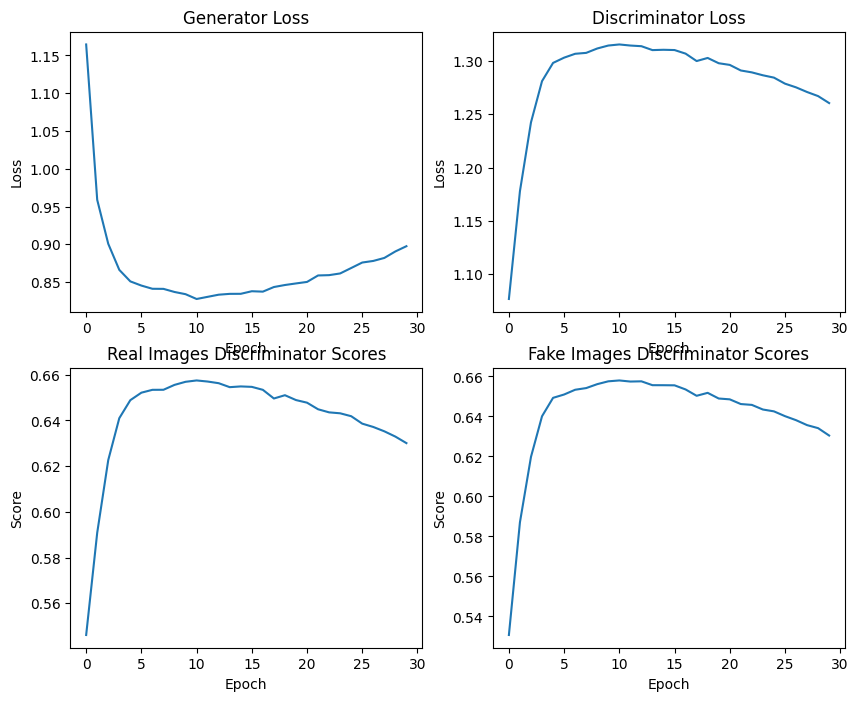

In [19]:
plt.figure(figsize=(10, 8), dpi=100)

plt.subplot(2, 2, 1)
plt.plot(losses_g, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')

plt.subplot(2, 2, 2)
plt.plot(losses_d, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')

plt.subplot(2, 2, 3)
plt.plot(real_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Real Images Discriminator Scores')

plt.subplot(2, 2, 4)
plt.plot(fake_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Fake Images Discriminator Scores')

In [21]:
pt.save(generator.state_dict(), "models/generator-model")
pt.save(discriminator.state_dict(), "models/discriminator-model")